In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
from sphMath.kernels import getKernelEnum

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 800
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3

gamma = 5/3
initialStateLeft = sodInitialState(1, 1, 0)
initialStateRight = sodInitialState(0.1795, 0.25, 0)
ratio = 1
smoothIC = False
timeLimit = 0.15

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.NoScheme

domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
timesteps = int(timeLimit / dt)

True: dxs: [tensor(0.0012, device='cuda:0')], ns: [tensor(800, device='cuda:0', dtype=torch.int32)], nx: 800
True: dxs: [tensor(0.0012, device='cuda:0')], ns: [tensor(800, device='cuda:0', dtype=torch.int32)], nx: 800
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001


In [4]:
f'{dt.item():.2e}'

'1.80e-04'

In [17]:
timesteps = 100

In [65]:
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.modules.density import computeDensity

In [66]:
# solverConfig['support']['scheme'] = None
# solverConfig['diffusionSwitch']['scheme'] = None

In [67]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

neighborhood, neighbors = evaluateNeighborhood(simulationState.systemState, solverConfig['domain'], kernel, verletScale = 1.4, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeDkDh = True, computeHessian = False, useCheckpoint=False)
simulationState.neighborhoodInfo = neighborhood
simulationState.systemState.densities = computeDensity(simulationState.systemState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    states.append(copy.deepcopy(simulationState))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })


  0%|          | 0/100 [00:00<?, ?it/s]

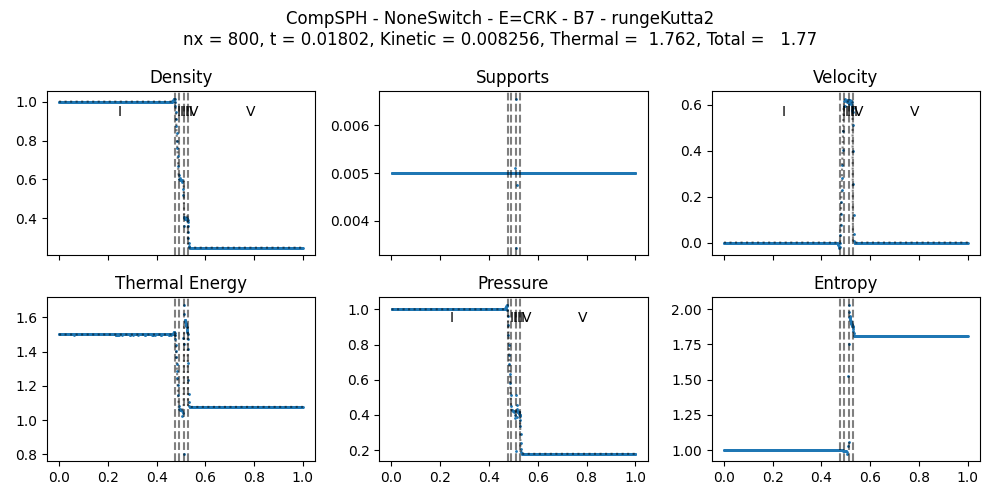

In [68]:
plotSod(states[-1], solverConfig, states[0].domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [69]:
referenceState = copy.deepcopy(states[-1])

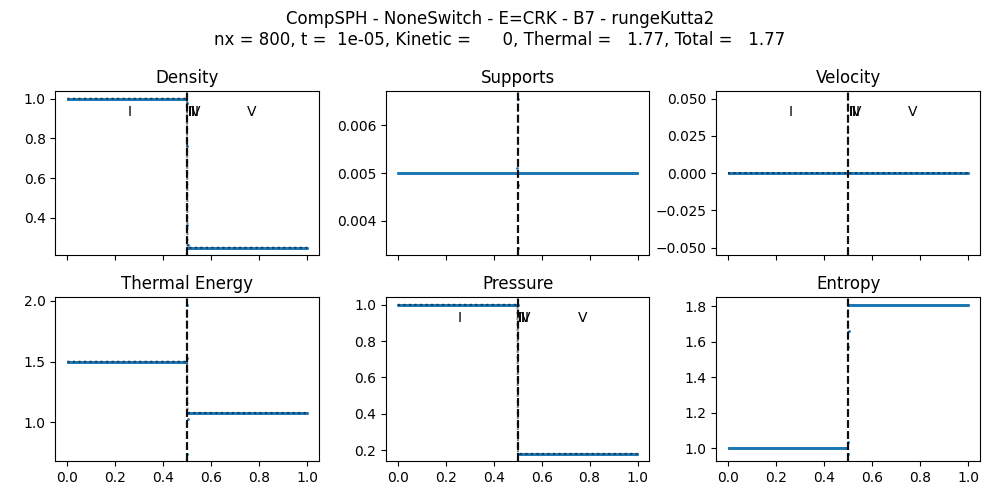

In [70]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.01 * simulationState.systemState.masses.max()

masses.requires_grad = True
simulationState.systemState.masses = masses

with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [71]:


# for i in (tq:=tqdm(range(timesteps))):
#     simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
#     simulationState.priorStep = [updates[-1], currentState[-1]]
    
#     with torch.no_grad():
#         states.append(simulationState.nograd().to(device='cpu'))

#     kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
#     thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
#     totalEnergy = kineticEnergy + thermalEnergy

#     tq.set_postfix({
#         'Kinetic Energy': kineticEnergy.item(),
#         'Thermal Energy': thermalEnergy.item(),
#         'Total Energy': totalEnergy.item(),
#         'Time': simulationState.t.item()
#     })


In [72]:

# with torch.no_grad():
#     plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [73]:
# rhoLoss = torch.mean((simulationState.systemState.densities - referenceState.systemState.densities)**2)
# rhoLoss.backward()

In [74]:
fourierModes = 32
weights = torch.rand(fourierModes, device=device, dtype=dtype)
noise = torch.zeros_like(simulationState.systemState.masses)
for i in range(fourierModes):
    noise += weights[i] * torch.sin(2 * torch.pi * i * simulationState.systemState.positions[:,0]) / 10

print(noise.min(), noise.max())

tensor(-1.1629, device='cuda:0') tensor(1.1629, device='cuda:0')


In [88]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.1 * simulationState.systemState.masses

# masses = simulationState.systemState.masses.detach().clone() + noise * simulationState.systemState.masses * 0.01


initialMasses = masses.clone()


massIterations = []

masses.requires_grad = True
simulationState.systemState.masses = masses

optimizer = torch.optim.AdamW([masses], lr = 1e-3)

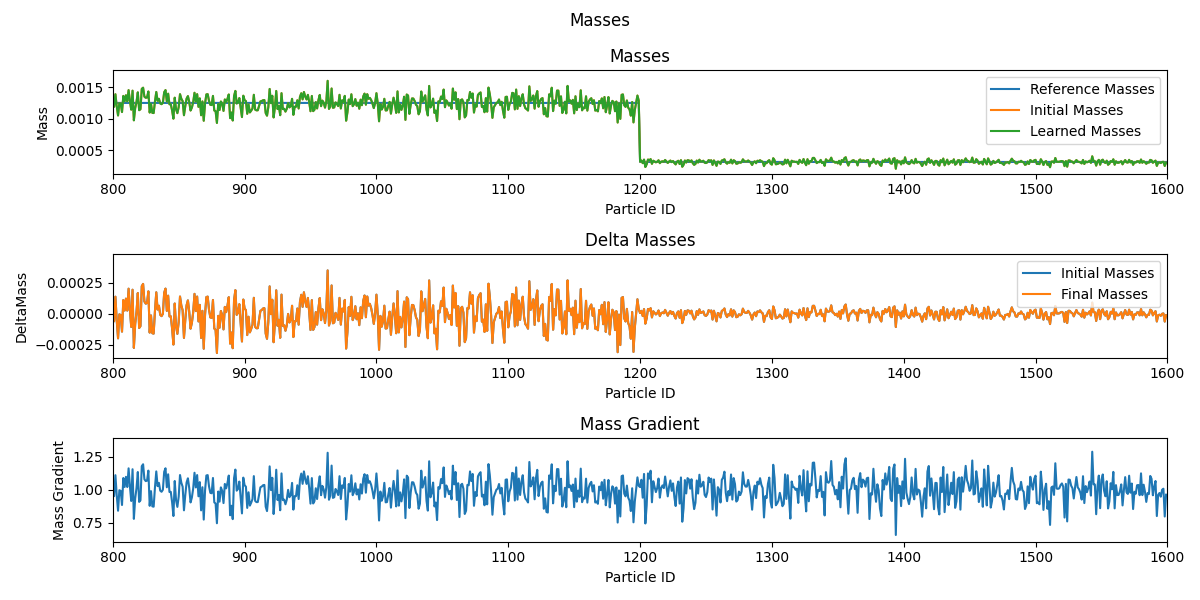

In [89]:
fig, axis = plt.subplots(3, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].set_xlim(nx,2*nx)
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].set_xlim(nx,2*nx)
axis[1,0].legend()

axis[2,0].plot(masses.detach().cpu().numpy() / referenceState.systemState.masses.detach().cpu().numpy(), label = 'Mass Gradient')
axis[2,0].set_title('Mass Gradient')
axis[2,0].set_xlabel('Particle ID')
axis[2,0].set_ylabel('Mass Gradient')
axis[2,0].set_xlim(nx,2*nx)
# axis[2,0].legend()

fig.tight_layout()

In [90]:
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.modules.density import computeDensity

In [96]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

# masses = simulationState.systemState.masses.detach().clone() + noise * simulationState.systemState.masses.mean() * 0.1
masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.1 * simulationState.systemState.masses

initialMasses = masses.clone()


massIterations = []

masses.requires_grad = True
simulationState.systemState.masses = masses

optimizer = torch.optim.AdamW([masses], lr = 1e-4)

for i in (tq:=tqdm(range(250))):
    optimizer.zero_grad()
    simulationState = copy.deepcopy(particleSystem)
    simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
    simulationState.systemState.masses = masses

    neighborhood, neighbors = evaluateNeighborhood(simulationState.systemState, solverConfig['domain'], kernel, verletScale = 1.4, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeDkDh = True, computeHessian = False, useCheckpoint=False)
    simulationState.neighborhoodInfo = neighborhood
    simulationState.systemState.densities = computeDensity(simulationState.systemState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)


    priorStep = None

    for ii in (t:=tqdm(range(timesteps), leave=False)):
        simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
        simulationState.priorStep = [updates[-1], currentState[-1]]
        
    # rhoLoss.backward()

    rhoLoss = torch.mean((simulationState.systemState.densities - referenceState.systemState.densities)**2)
    thermalEnergyLoss = torch.mean((simulationState.systemState.internalEnergies - referenceState.systemState.internalEnergies)**2)
    positionLoss = torch.mean((simulationState.systemState.positions - referenceState.systemState.positions)**2)
    
    loss = rhoLoss + thermalEnergyLoss + positionLoss
    # loss = thermalEnergyLoss
    loss.backward()

    # maxGradient = torch.max(torch.abs(masses.grad))
    # if maxGradient > 0.01 * simulationState.systemState.masses.max():
        # print(f'Clamping gradients: {maxGradient.item()}')
        # Clamp gradients to prevent large updates
        # masses.grad = masses.grad / maxGradient * 0.1 * referenceState.systemState.masses.mean()
        # Clamp the gradients to a reasonable range
        # print(f'Clamped gradients: {torch.max(torch.abs(masses.grad)).item()}')
    # torch.nn.utils.clip_grad_value_([masses], 10.0 * simulationState.systemState.masses.mean())
    # masses.grad.clamp_(-0.01 * simulationState.systemState.masses.max(), 0.01 * simulationState.systemState.masses.max())

    optimizer.step()
    # masses.clamp_(0.01 * referenceState.systemState.masses.min(), 10 * referenceState.systemState.masses.max())

    # if i % 25 == 0:
        # optimizer.param_groups[0]['lr'] *= 0.5

    tq.set_postfix({
        'Rho Loss': rhoLoss.item(),
        'Thermal Energy Loss': thermalEnergyLoss.item(),
        'Position Loss': positionLoss.item(),
        'Masses': (masses.detach().cpu().numpy().min(), masses.detach().cpu().numpy().max(), masses.detach().cpu().numpy().mean()),
    })

    axis[0,0].cla()
    axis[1,0].cla()
    axis[2,0].cla()
    axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses', c = 'black')
    axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
    axis[0,0].plot(masses.detach().cpu().numpy(), label = 'Learned Masses')
    axis[0,0].set_title('Masses')
    axis[0,0].set_xlabel('Particle ID')
    axis[0,0].set_ylabel('Mass')
    axis[0,0].set_xlim(nx,2*nx)
    axis[0,0].legend()

    axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
    axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
    axis[1,0].set_title('Delta Masses')
    axis[1,0].set_xlabel('Particle ID')
    axis[1,0].set_ylabel('DeltaMass')
    axis[1,0].set_xlim(nx,2*nx)
    # axis[1,0].legend()
        
    axis[2,0].plot(masses.grad.detach().cpu().numpy(), label = 'Mass Gradient')
    axis[2,0].set_title('Mass Gradient')
    axis[2,0].set_xlabel('Particle ID')
    axis[2,0].set_ylabel('Mass Gradient')
    axis[2,0].set_xlim(nx,2*nx)

    fig.suptitle(f'Masses - Iteration {i+1} - Loss: {loss.item():.2e} - Rho Loss: {rhoLoss.item():.2e} - Thermal Energy Loss: {thermalEnergyLoss.item():.2e} - Position Loss: {positionLoss.item():.2e}')

    fig.canvas.draw()
    fig.canvas.flush_events()
    # massIterations.append(masses.detach().cpu().numpy().copy())
    

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

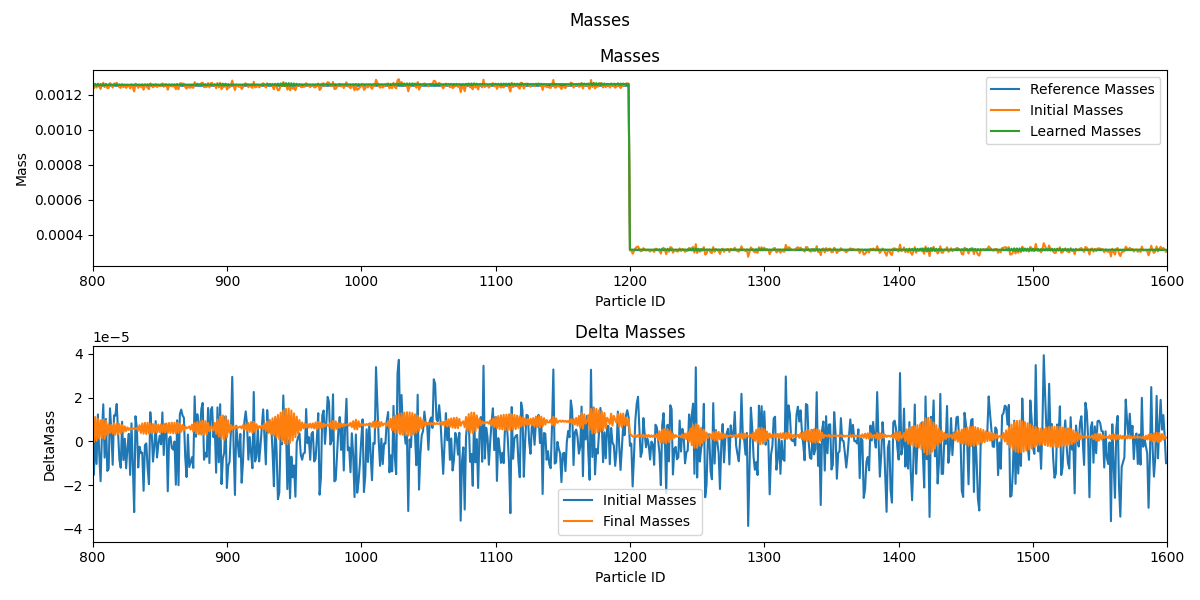

In [63]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].set_xlim(nx,2*nx)
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].set_xlim(nx,2*nx)
axis[1,0].legend()

fig.tight_layout()

In [66]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
simulationState.systemState.masses = masses

for i in (t:=tqdm(range(862), leave=False)):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    

  0%|          | 0/862 [00:00<?, ?it/s]

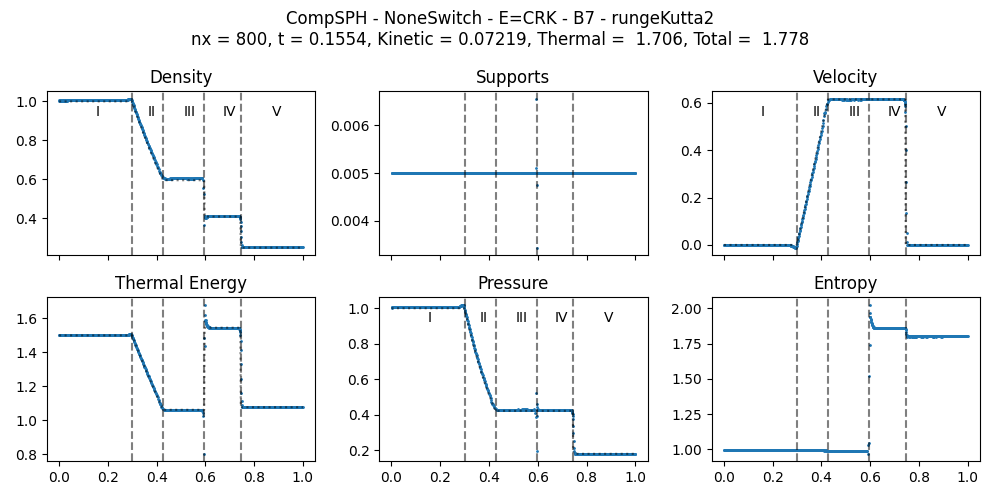

: 

In [ ]:
with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

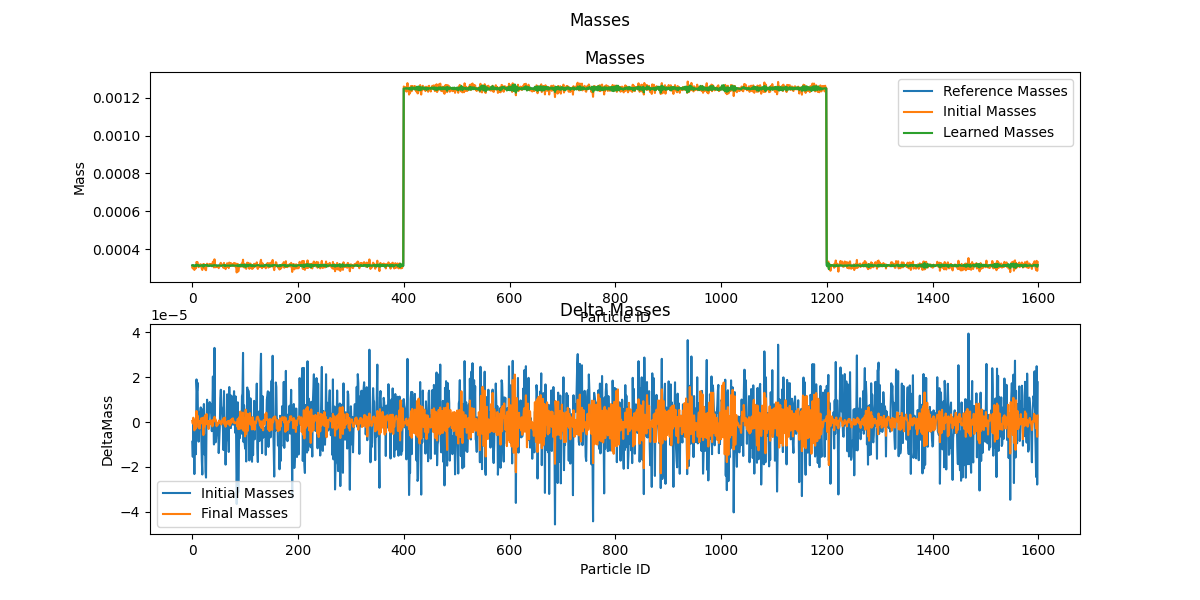

In [38]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].legend()
